In [275]:
import datetime, time
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from functools import reduce
import os
import matplotlib.pyplot as plt


#from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_selection import chi2, RFECV, SelectKBest
from sklearn.decomposition import PCA, NMF
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import (confusion_matrix,  precision_recall_curve, auc, accuracy_score, 
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, scorer )
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler, normalize, MaxAbsScaler




import xgboost as xgb
import plotly
#import luminol
import plotly.plotly as py
import plotly.graph_objs as go

from fbprophet import Prophet

from keras.models import Model, Sequential, load_model
from keras.layers import LSTM, Input, Dense
from keras.layers import RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import plot_model
from keras import regularizers


from sklearn.metrics import mean_squared_error

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [2]:
plotly.tools.set_credentials_file(username='smillett', api_key='MXYpm8AMvEte7SSw6dKu')

This is to setup the sparksession. If additional resources need to be allocated it is done with this command

# Import CSV Data

In [3]:
# proc_sample.columns

In [4]:
start_time = time.time()
master_df = pd.read_csv('../Dataset/Output/complete_5m_df.csv')
print("--- %s seconds ---" % (time.time() - start_time))

--- 183.32523679733276 seconds ---


In [5]:
master_df = master_df.replace(-999, 0)
#master_df['redteam_event'] = master_df.redteam_event.map(lambda x: 1 if x > 0 else x)

In [6]:
resampled_df = master_df.groupby('time').agg({'redteam_event':'sum',
                                               'dns_count':'mean',
                                               'newresolved_count':'mean',
                                               'fail_count':'mean',
                                               'LoggedOn':'mean',
                                               'dur':'mean',
                                               'pkt_cnt':'mean',
                                               'byte_cnt':'mean',
                                               'avg_pkt_size':'mean',
                                               'proc_total':'mean',
                                               'proc_exec_total':'mean',
                                               'newexecute_count':'mean',
                                               'Proc_run':'mean'} )
resampled_df['redteam_event'] = resampled_df.redteam_event.map(lambda x: 1 if x > 0 else x)

In [7]:
master_df.shape

(129295890, 15)

In [8]:
resampled_df.shape

(10081, 13)

In [7]:
#Final Dataset with normalized data across all features
normalized_df = pd.DataFrame(index=resampled_df.index)

#Dataset with which shows the  data across all features
timeseries_df = pd.DataFrame(index=resampled_df.index)
for columns in resampled_df[resampled_df.columns.difference(['redteam_event','src_comp'])]:
    m=Prophet()
    prophet_test = pd.DataFrame({'ds':resampled_df.index,'y':resampled_df[columns]})
    m.fit(prophet_test)
    future=m.make_future_dataframe(periods=0)
    forecast=m.predict(future)
    timeseries_df[columns] = forecast['yhat'].values
    normalized_df[columns] = resampled_df[columns] - forecast['yhat'].values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

In [8]:

seq_in = resampled_df.LoggedOn.copy().values
seq_in /= np.max(np.abs(seq_in),axis=0)

X_train, X_test = train_test_split(seq_in, test_size=0.2, random_state=1234)

n_in = 1
encoding_dim = 14

# seq_in = seq_in.reshape((1, n_in, 1))
# prepare output sequence
# seq_out = seq_in[:, 1:, :]
# n_out = n_in - 1

input_layer = Input(shape=(n_in, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(n_in, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

# # define encoder
# visible = Input(shape=(n_in,1))
# encoder = LSTM(500, activation='relu')(visible)
# # define reconstruct decoder
# decoder1 = RepeatVector(n_in)(encoder)
# decoder1 = LSTM(288, activation='relu', return_sequences=True)(decoder1)
# decoder1 = TimeDistributed(Dense(288))(decoder1)
# # define predict decoder
# decoder2 = RepeatVector(n_out)(encoder)
# decoder2 = LSTM(288, activation='relu', return_sequences=True)(decoder2)
# decoder2 = TimeDistributed(Dense(1))(decoder2)
# # tie it together
# model = Model(inputs=visible, outputs=[decoder1, decoder2])
# model.compile(optimizer='adam', loss='mse')
# plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoder.png')

In [11]:
# nb_epoch = 100
# batch_size = 32

# autoencoder.compile(optimizer='adam', 
#                     loss='mean_squared_error', 
#                     metrics=['accuracy'])

# checkpointer = ModelCheckpoint(filepath="model.h5",
#                                verbose=0,
#                                save_best_only=True)
# tensorboard = TensorBoard(log_dir='./logs',
#                           histogram_freq=0,
#                           write_graph=True,
#                           write_images=True)

# history = autoencoder.fit(X_train, X_train,
#                     epochs=nb_epoch,
#                     batch_size=batch_size,
#                     shuffle=True,
#                     validation_data=(X_test, X_test),
#                     verbose=1,
#                     callbacks=[checkpointer, tensorboard]).history

In [12]:
# plt.plot(history['loss'])
# plt.plot(history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right');

In [13]:
# history = model.fit(seq_in, [seq_in,seq_out], epochs=20, verbose=2)



In [14]:
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [15]:
# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [16]:
# yhat=model.predict(seq_in, verbose=2)
# y = resampled_df.LoggedOn.copy().values
# y /= np.max(np.abs(y),axis=0)
# n_in = len(y)
# y = y.reshape((1, n_in, 1))

# yhat=model.predict(y, verbose=2)

In [17]:
# # Plot training & validation loss values
# plt.plot(yhat[0][0,:,0])

# plt.title('Models')
# plt.ylabel('actual value')
# plt.xlabel('time')
# plt.legend(['yhat'], loc='upper left')
# plt.show()

In [18]:
# print(yhat[1][0,:,0])

In [19]:
# print(y)

In [20]:
normalized_df.head()

,LoggedOn,Proc_run,avg_pkt_size,byte_cnt,dns_count,dur,fail_count,newexecute_count,newresolved_count,pkt_cnt,proc_exec_total,proc_total
time,,,,,,,,,,,,
2017-01-01 00:00:00,0.913137,1.335985,3.373103,-7115.624888,0.025316,-6.080176,0.022276,2.321454,0.022183,-133.231825,1.618704,2.027763
2017-01-01 00:05:00,0.209978,-0.190086,-9.669390,-137718.012672,0.014486,-10.735224,0.020597,0.179098,0.011984,-277.480413,-0.095496,0.025029
2017-01-01 00:10:00,0.069941,-0.278272,-7.918636,-119028.830569,0.013233,-10.439069,0.004263,0.095575,0.010141,-263.260863,-0.209260,-0.149414
2017-01-01 00:15:00,-0.266092,-0.461024,-12.584954,-99373.561851,0.027207,-10.452807,-0.001399,-0.112882,0.012189,-239.928555,-0.410915,-0.395525
2017-01-01 00:20:00,-0.217041,-0.381126,-12.257914,-105317.025054,0.009241,-12.006434,0.003985,-0.040716,0.006932,-238.182820,-0.320702,-0.307842


In [9]:
normalized_df.reset_index(inplace=True)
ds = resampled_df['redteam_event']
ds = ds.map({0:False, 1:True})
def get_delay(ds):
    x1 = (~ds).cumsum()
    x2 = x1.where(ds, np.nan).ffill()
    return x1 - x2

ds = get_delay(ds).replace(np.nan,0)
#ds = ds.map({False:0, True:1})
resampled_df['last_redteam_event'] = ds
normalized_df = normalized_df.merge(resampled_df['last_redteam_event'].reset_index(), on='time',how='left')

# Basic stats on dataset

In [22]:
resampled_df.head()

,redteam_event,dns_count,newresolved_count,fail_count,LoggedOn,dur,pkt_cnt,byte_cnt,avg_pkt_size,proc_total,proc_exec_total,newexecute_count,Proc_run,last_redteam_event
time,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.0,0.033681,0.026528,0.067362,3.529657,22.837556,520.047988,497002.288525,55.782690,4.544858,3.469747,2.667064,2.816393,0.0
2017-01-01 00:05:00,0.0,0.023250,0.016352,0.065662,2.824221,18.157895,374.563618,365614.214103,42.708237,2.544200,1.758048,0.523761,1.292795,0.0
2017-01-01 00:10:00,0.0,0.022392,0.014531,0.049309,2.681991,18.431872,387.640067,383592.880896,44.429815,2.371844,1.646737,0.439257,1.207003,0.0
2017-01-01 00:15:00,0.0,0.036756,0.016599,0.043633,2.343846,18.398387,409.925777,402614.909414,39.737081,2.127816,1.447475,0.229784,1.026559,0.0
2017-01-01 00:20:00,0.0,0.019176,0.011364,0.049006,2.390862,16.827415,410.724195,396116.731771,40.040411,2.217566,1.540009,0.300900,1.108665,0.0


In [23]:
resampled_df[['dns_count','redteam_event']].groupby('redteam_event').count()

,dns_count
redteam_event,
0.0,9754
1.0,327


# Visual data exploration

In [10]:
#remove daily variance

y_logged_test = resampled_df['dur']
logged_diff = list()
min_5_block = 288
for i in range(min_5_block, len(y_logged_test)):
    value = y_logged_test[i] - y_logged_test[i - min_5_block]
    logged_diff.append(value)

In [16]:
redteam_events = resampled_df[resampled_df['redteam_event']>0].index
LoggedOn = go.Scatter(x=resampled_df.index,y=logged_diff)
data = [LoggedOn]
vertlines = []

for dates in redteam_events:
    vertlines.append(dict(
        type = 'line',
        x0=dates,
        y0= -50,
        x1=dates,
        y1=50,
        layer='below',
        line= dict(
        color= 'rgb(255, 0, 0)',
        width= 3))
    )
layout = dict(shapes=vertlines)
fig = dict(data=data, layout=layout)
py.iplot(fig)

PlotlyRequestError: Account limit reached: Your account is limited to creating 25 charts. To continue, you can override or delete existing charts or you can upgrade your account at: https://plot.ly/products/cloud

In [ ]:
redteam_events = resampled_df[resampled_df['redteam_event']>0].index
LoggedOn = go.Scatter(x=resampled_df.index,y=normalized_df['dur'].values)
data = [LoggedOn]
vertlines = []

for dates in redteam_events:
    vertlines.append(dict(
        type = 'line',
        x0=dates,
        y0= -30,
        x1=dates,
        y1=30,
        layer='below',
        line= dict(
        color= 'rgb(255, 0, 0)',
        width= 3))
    )
layout = dict(shapes=vertlines)
fig = dict(data=data, layout=layout)
py.iplot(fig)

# Model Creation

In [137]:
y = resampled_df.redteam_event.values
X = normalized_df[normalized_df.columns.difference(['redteam_event','time','index','last_redteam_event'])].values

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.50,stratify=y )

In [139]:
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=.33,stratify=y_test )

In [140]:
strtCV = StratifiedKFold(n_splits=10)

pipe = Pipeline([('normal',StandardScaler()),
                  ('scale', SMOTE()), 
                  ('clf', LogisticRegression())])

In [146]:
N_FEATURES_OPTIONS = [1,2]

#RandomForestClassifier()
C_OPTIONS = [1e-2, 1e-1, 1e0, 1e1,1e2]

In [36]:
scorer.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

## Classification process

In [282]:
param_grid = [
    {
        'scale__k_neighbors':N_FEATURES_OPTIONS,
        'clf':[SVC(probability=True),LogisticRegression()],
        'clf__C': C_OPTIONS,
        'clf__tol':C_OPTIONS,
        'normal':[None,StandardScaler()]
    },
    {
        'scale__k_neighbors':N_FEATURES_OPTIONS,
        'clf':[RandomForestClassifier()],
        'clf__n_estimators': [50, 75, 100, 125],
        'clf__min_samples_leaf': [10, 25, 50],
        'clf__oob_score': [True, False],
        'clf__max_features': ['auto', 'sqrt', 'log2'],
        'normal':[None,StandardScaler()]
    },
    {
        'scale__k_neighbors':N_FEATURES_OPTIONS,
        'clf':[xgb.XGBClassifier()],
        'clf__nthread':[4], #when use hyperthread, xgboost may become slower
          'clf__objective':['binary:hinge','binary:logistic'],
          'clf__learning_rate': [0.05,0.005], #so called `eta` value
          'clf__max_depth': [8,9,10],
          'clf__min_child_weight': [3,4],
          'clf__silent': [1],
          'clf__subsample': [.5,0.8],
          'clf__colsample_bytree': [0.7],
          'clf__n_estimators': [1000,2500], #number of trees, change it to 1000 for better results
          'clf__seed': [1337], 
            
          
        'normal':[None,StandardScaler()]
    }
]
grid = GridSearchCV(pipe, param_grid, cv=strtCV, scoring='f1_macro',verbose=5,n_jobs=20)

grid.fit(X_train, y_train)

Fitting 10 folds for each of 872 candidates, totalling 8720 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:   40.1s
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:  2.5min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  3.5min
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:  4.8min
[Parallel(n_jobs=20)]: Done 842 tasks      | elapsed:  6.4min
[Parallel(n_jobs=20)]: Done 1112 tasks      | elapsed:  6.9min
[Parallel(n_jobs=20)]: Done 1418 tasks      | elapsed:  7.1min
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:  7.2min
[Parallel(n_jobs=20)]: Done 2138 tasks      | elapsed:  7.5min
[Parallel(n_jobs=20)]: Done 2552 tasks      | elapsed:  8.0min
[Parallel(n_jobs=20)]: Done 3002 tasks      | elapsed:  8.5min
[Parallel(n_jobs=20)]: Done 3488 tasks      | elapsed:  9.0min
[Parallel(n_jobs=20)]: Done 4010 tasks      | elapsed:  9.6min
[Parallel(n_jobs=20)]: Done 4568 tasks      | e

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('normal', StandardScaler(copy=True, with_mean=True, with_std=True)), ('scale', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=None, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('clf', LogisticRegre...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=20,
       param_grid=[{'scale__k_neighbors': [1, 2], 'clf': [SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False), LogisticRegre...], 'clf__seed': [1337], 'normal': [None, StandardScaler(copy=True, with_m

In [220]:
# print("grid.best_score_ {}".format(grid.best_score_))
# print("grid.best_params_ {}".format(grid.best_params_))
# print("grid.best_estimator_ {}".format(grid.best_estimator_))

In [221]:
# xgb_model = xgb.XGBClassifier()

# xgb_pipe = Pipeline([('normal',StandardScaler()),
#                   ('scale', SMOTE()), 
#                   ('clf', xgb.XGBClassifier())])

# #brute force scan for all parameters, here are the tricks
# #usually max_depth is 6,7,8
# #learning rate is around 0.05, but small changes may make big diff
# #tuning min_child_weight subsample colsample_bytree can have 
# #much fun of fighting against overfit 
# #n_estimators is how many round of boosting
# #finally, ensemble xgboost with multiple seeds may reduce variance
# parameters = {'clf__nthread':[4], #when use hyperthread, xgboost may become slower
#               'clf__objective':['binary:hinge','binary:logistic'],
#               'clf__learning_rate': [0.05,0.005], #so called `eta` value
#               'clf__max_depth': [8,9,10],
#               'clf__min_child_weight': [3,4],
#               'clf__silent': [1],
#               'clf__subsample': [.5,0.8],
#               'clf__colsample_bytree': [0.7],
#               'clf__n_estimators': [1000,2500], #number of trees, change it to 1000 for better results
#               'clf__seed': [1337], 
#               'scale__k_neighbors':N_FEATURES_OPTIONS,
#              'normal':[None,StandardScaler() ]}


# xg_grid = GridSearchCV(xgb_pipe, parameters, n_jobs=25, 
#                    cv=strtCV, 
#                    scoring='precision_weighted',
#                    verbose=3, refit=True)

# xg_grid.fit(X_train, y_train)

In [222]:
# print("grid.best_score_ {}".format(xg_grid.best_score_))
# print("grid.best_params_ {}".format(xg_grid.best_params_))
# print("grid.best_estimator_ {}".format(xg_grid.best_estimator_))

In [223]:
# xg_grid.best_params_

## Comparing classification models

In [283]:
test = grid.cv_results_

model_score={}
for classifier,score,para in zip(test['param_clf'],test['mean_test_score'],test['params']):
    if classifier.__class__.__name__ not in model_score.keys():
        model_score[classifier.__class__.__name__] = []

    model_score[classifier.__class__.__name__].append(score)
    
best_models = {}
for classifier,score,para in zip(test['param_clf'],test['mean_test_score'],test['params']):
    clf_name=classifier.__class__.__name__
    if clf_name not in best_models.keys():
        best_models[clf_name] = {}
        best_models[clf_name]['best_accuracy'] = 0
        
    if score > best_models[clf_name]['best_accuracy']:
        best_models[clf_name]['best_accuracy'] = score
        best_models[clf_name]['model'] = classifier


In [284]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore')


for key,model in best_models.items():
    model['model'].fit(X_train, y_train)
    y_test_pred=model['model'].predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test,model['model'].predict_proba(X_test)[:,1])
    best_models[key]['fpr'] = fpr
    best_models[key]['tpr'] = tpr
    best_models[key]['thresholds'] = thresholds
    print('Classification Report for '+key)
    print(classification_report(y_test,y_test_pred))
    print(confusion_matrix(y_test,y_test_pred))
    print(accuracy_score(y_test,y_test_pred))

Classification Report for SVC
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      3267
         1.0       0.00      0.00      0.00       110

   micro avg       0.97      0.97      0.97      3377
   macro avg       0.48      0.50      0.49      3377
weighted avg       0.94      0.97      0.95      3377

[[3267    0]
 [ 110    0]]
0.9674267100977199
Classification Report for LogisticRegression
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      3267
         1.0       0.00      0.00      0.00       110

   micro avg       0.97      0.97      0.97      3377
   macro avg       0.48      0.50      0.49      3377
weighted avg       0.94      0.97      0.95      3377

[[3267    0]
 [ 110    0]]
0.9674267100977199
Classification Report for RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      3267
         1.0       0.

In [359]:
plt.rc('legend',**{'fontsize':18})
#plt.rc('title',**{'fontsize':20})

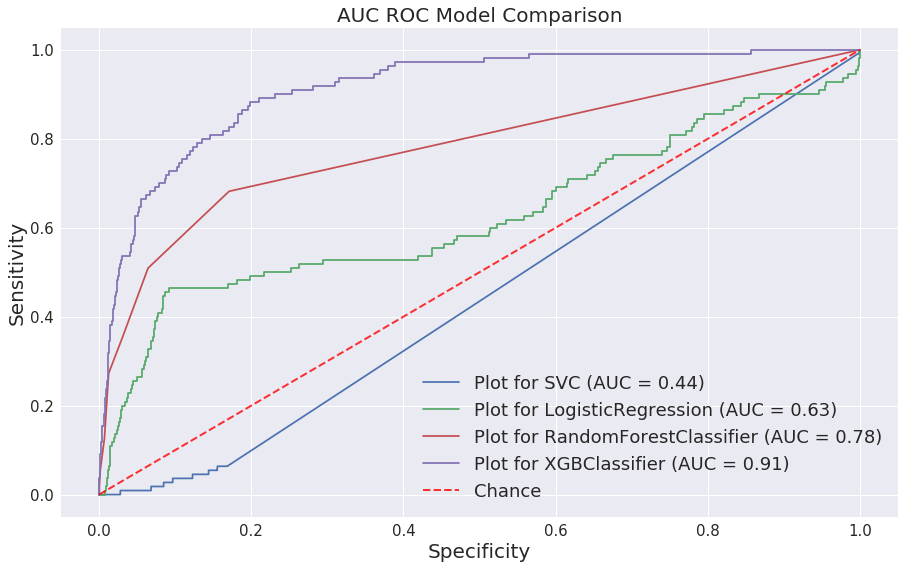

In [360]:
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
for key,model in best_models.items():
    roc_auc = auc(model['fpr'],model['tpr'])
    ax.plot(model['fpr'],model['tpr'], label=('Plot for %s (AUC = %0.2f)' % (key, roc_auc)))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.legend(loc="best")
plt.xlabel('Specificity', fontsize=20)
plt.ylabel('Sensitivity', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('AUC ROC Model Comparison', fontsize=20)
plt.savefig('./Output/AUC_Model_Comparison.png')
plt.show()

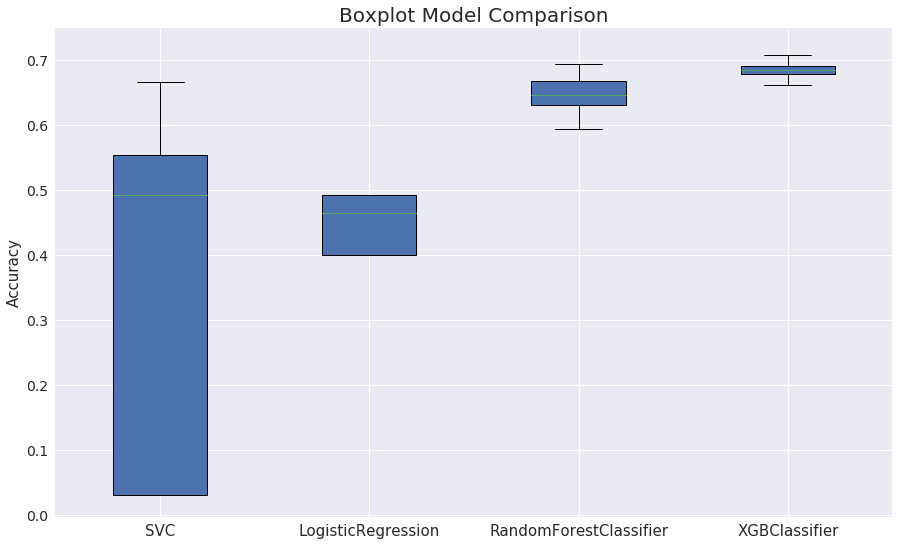

In [372]:

fig = plt.figure(1, figsize=(15, 9))

# Create an axes instance
ax = fig.add_subplot(111)

bp = ax.boxplot(model_score.values(), patch_artist=True)
ax.set_xticklabels(model_score.keys(), fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
#ax.set_ylim(.90,1.0)
plt.title("Boxplot Model Comparison", fontsize=20)
plt.savefig('./Output/Boxplot_Model_Comparison.png')

plt.show()

# Final Model

In [287]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('normal', StandardScaler(copy=True, with_mean=True, with_std=True)), ('scale', SMOTE(k_neighbors=1, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=None, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('clf', XGBClassifier...,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=1,
       subsample=0.8))])

In [288]:
best_models

{'SVC': {'best_accuracy': 0.6665028093921422,
  'model': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False),
  'fpr': array([0.00000000e+00, 3.06091215e-04, 2.78543006e-02, 2.78543006e-02,
         6.82583410e-02, 6.82583410e-02, 8.47872666e-02, 8.47872666e-02,
         9.67248240e-02, 9.67248240e-02, 1.22742577e-01, 1.22742577e-01,
         1.43862871e-01, 1.43862871e-01, 1.45699418e-01, 1.46311601e-01,
         1.47535966e-01, 1.48760331e-01, 1.49678604e-01, 1.50596878e-01,
         1.51515152e-01, 1.52127334e-01, 1.53045608e-01, 1.53657790e-01,
         1.54269972e-01, 1.55188246e-01, 1.55494337e-01, 1.56412611e-01,
         1.57024793e-01, 1.57330885e-01, 1.58249158e-01, 1.59473523e-01,
         1.60391797e-01, 1.61003979e-01, 1.62840526e-01, 1.64370983e-01,
         1.68350168e-01, 9.96939088e-

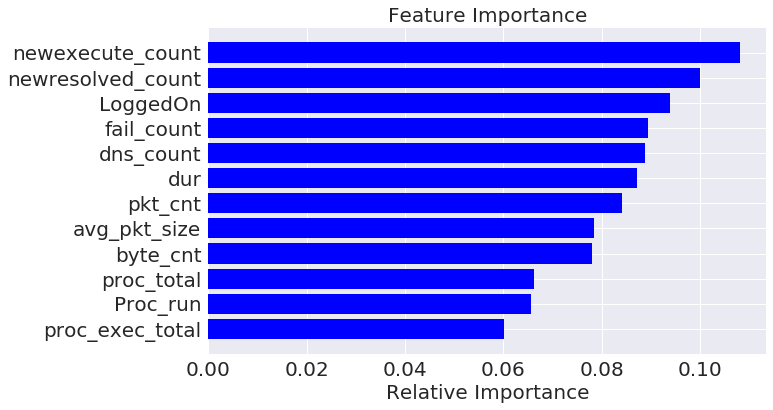

In [362]:
importances = grid.best_estimator_.named_steps['clf'].feature_importances_
labels = normalized_df[normalized_df.columns.difference(['redteam_event','time','index','last_redteam_event'])].columns
importances, labels = zip(*sorted(zip(importances, labels)))

#features = X.columns
#indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.title('Feature Importance', fontsize=20)
plt.barh(range(len(importances)), importances, color='b', align='center')
plt.yticks(range(len(labels)), labels, fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Relative Importance', fontsize=20)
plt.savefig('./Output/Feature_Importance.png')
plt.show()

In [363]:
best_models['XGBClassifier']['model'].fit(X_train, y_train)

y_pred = best_models['XGBClassifier']['model'].predict(X_validation)

mse = np.mean(np.power(y_validation - y_pred, 2))
error_df = pd.DataFrame({'reconstruction_error': best_models['XGBClassifier']['model'].predict_proba(X_validation)[:,1],
                        'true_class': y_validation})

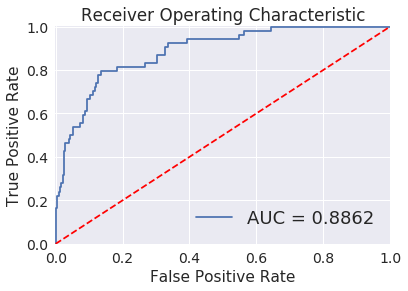

In [364]:

fpr, tpr, thresholds = roc_curve(y_validation,best_models['XGBClassifier']['model'].predict_proba(X_validation)[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

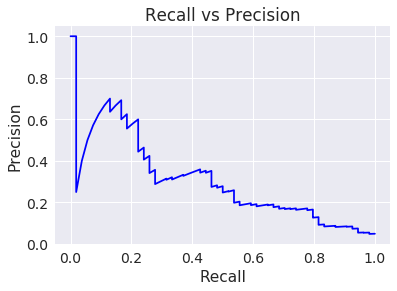

In [365]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

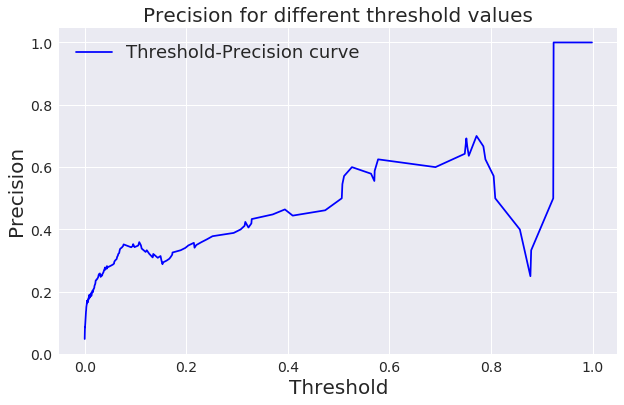

In [366]:
plt.figure(figsize=(10,6))
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values', fontsize=20)
plt.xlabel('Threshold', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.legend(loc="best")
plt.show()

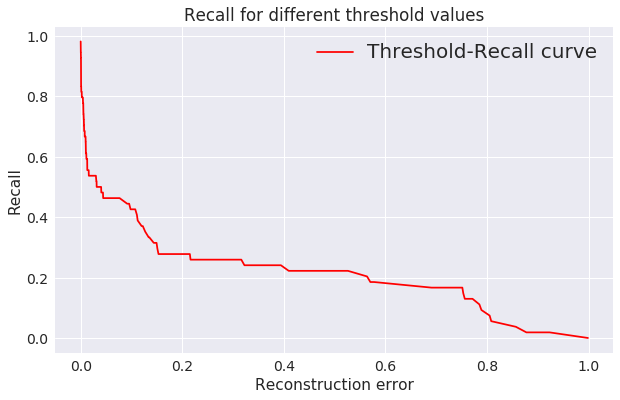

In [367]:
plt.figure(figsize=(10,6))
plt.plot(th, recall[1:], 'r', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.legend(loc="best")
plt.setp(plt.gca().get_legend().get_texts(), fontsize='20')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='20')
plt.savefig('./Output/Initial_Confusion_Matrix.png')
plt.show()

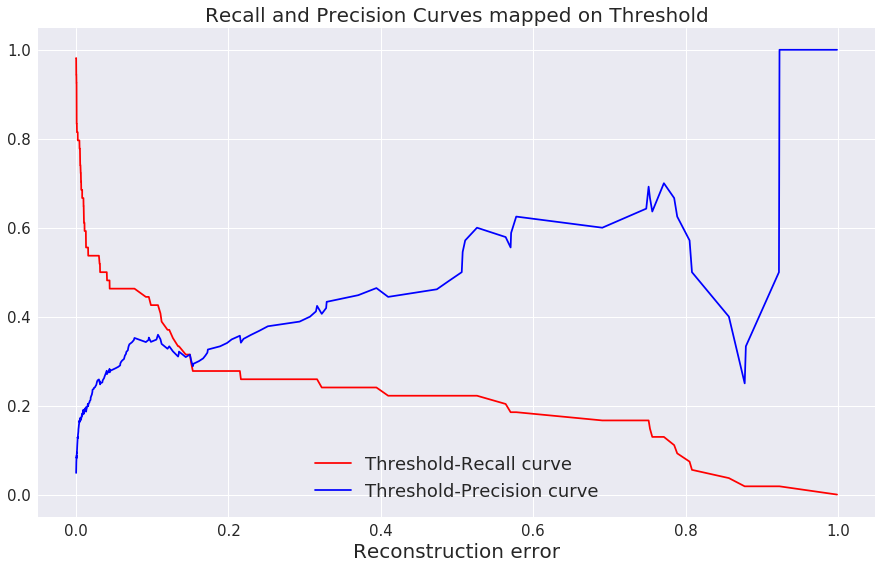

In [368]:
plt.figure(figsize=(15,9))
plt.title("Recall and Precision Curves mapped on Threshold", fontsize=20)
plt.plot(th, recall[1:], 'r', label='Threshold-Recall curve')
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.xlabel('Reconstruction error', fontsize=20)
plt.legend(loc="best")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('./Output/recall_precision_threshold.png')
plt.show()

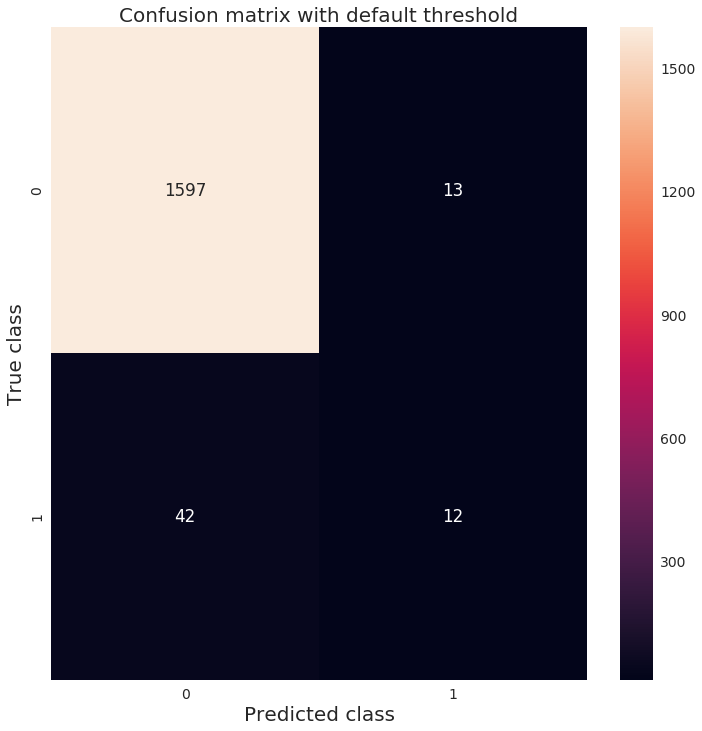

In [369]:
import seaborn as sns
threshold = .50
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
sns.set(font_scale=1.4)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix with default threshold",fontsize=20)
plt.ylabel('True class',fontsize=20)
plt.xlabel('Predicted class',fontsize=20)

plt.savefig('./Output/Initial_Confusion_Matrix.png')
plt.show()

In [370]:
confusion_matrix(y_validation,y_pred)

array([[1597,   13],
       [  42,   12]])

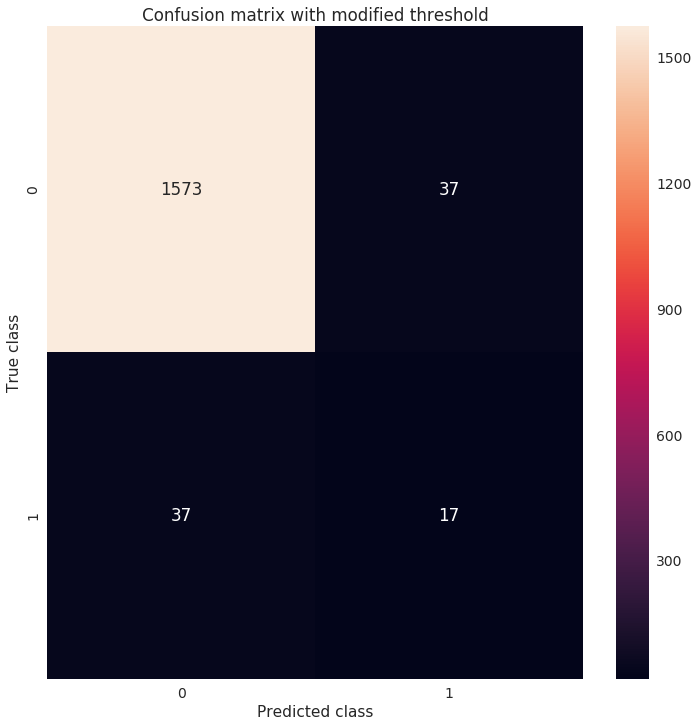

In [371]:
import seaborn as sns
threshold = .15
sns.set(font_scale=1.4)
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix with modified threshold")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('./Output/Final_Confusion_Matrix.png')
plt.show()

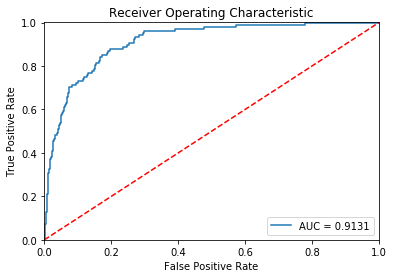

In [48]:

fpr, tpr, thresholds = roc_curve(y_test,xg_grid.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [47]:
xg_error_df = pd.DataFrame({'reconstruction_error': xg_grid.predict_proba(X_test)[:,1],
                        'true_class': y_test})

xg_error_df.describe()

,reconstruction_error,true_class
count,3327.000000,3327.000000
mean,0.078178,0.032462
std,0.178123,0.177249
min,0.004194,0.000000
25%,0.007395,0.000000
50%,0.015467,0.000000
75%,0.047887,0.000000
max,0.987609,1.000000


In [47]:
xg_error_df = pd.DataFrame({'reconstruction_error': xg_grid.predict_proba(X_test)[:,1],
                        'true_class': y_test})

xg_error_df.describe()

,reconstruction_error,true_class
count,3327.000000,3327.000000
mean,0.078178,0.032462
std,0.178123,0.177249
min,0.004194,0.000000
25%,0.007395,0.000000
50%,0.015467,0.000000
75%,0.047887,0.000000
max,0.987609,1.000000


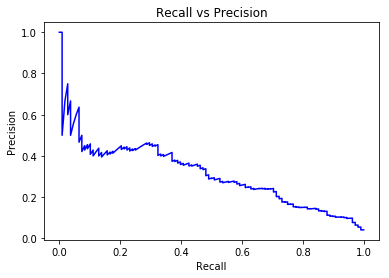

In [49]:
precision, recall, th = precision_recall_curve(xg_error_df.true_class, xg_error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

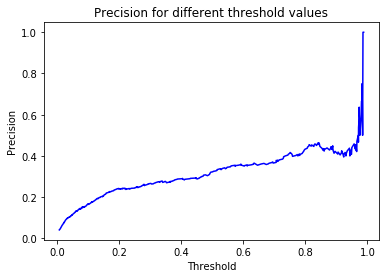

In [50]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

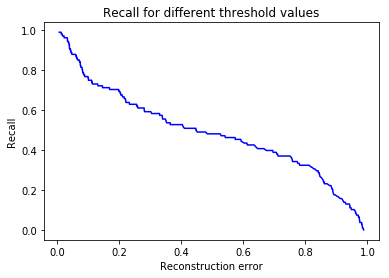

In [51]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

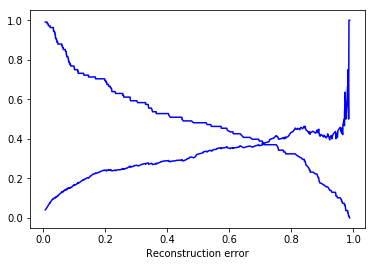

In [52]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.xlabel('Reconstruction error')
plt.show()

In [69]:
xg_y_pred=xg_grid.predict(X_test)
confusion_matrix(y_test,xg_y_pred)

array([[3109,  110],
       [  56,   52]])

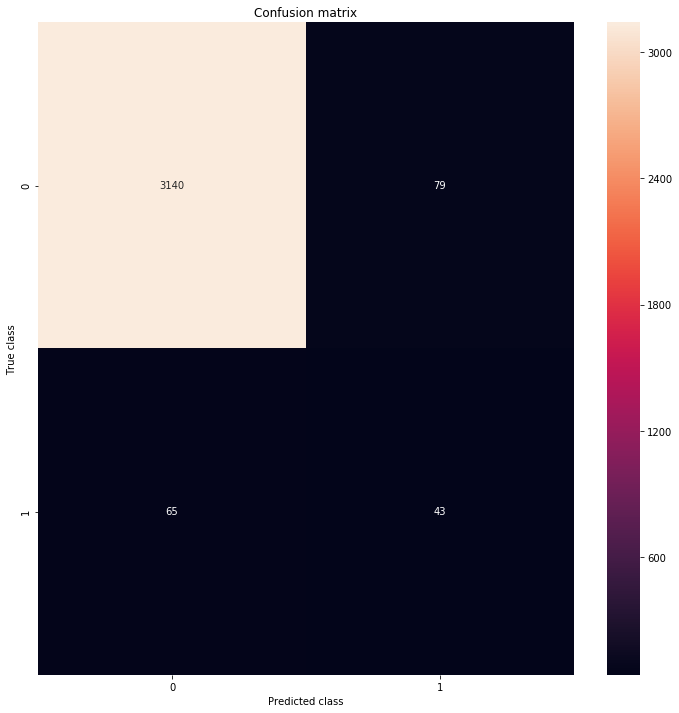

In [75]:
import seaborn as sns
threshold = .65
xg_y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(xg_error_df.true_class, xg_y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [60]:
#print(grid.best_estimator_.feature_importances_)

In [61]:
# plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
# plt.show()

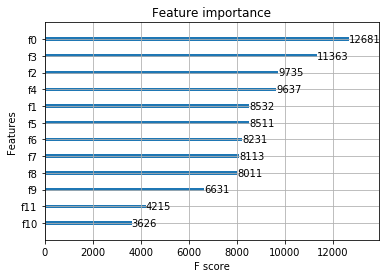

In [66]:
xgb.plot_importance(grid.best_estimator_.named_steps['clf'])
plt.show()

In [62]:
y_pred = grid.predict(X_test)

In [63]:
confusion_matrix(y_test,y_pred)

array([[3186,   33],
       [  82,   26]])

In [229]:
probs = grid.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

AttributeError: probability estimates are not available for loss='hinge'

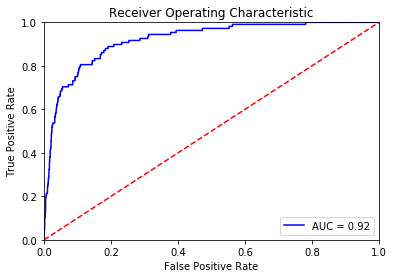

In [212]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [81]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[3219    0]
 [   0  108]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


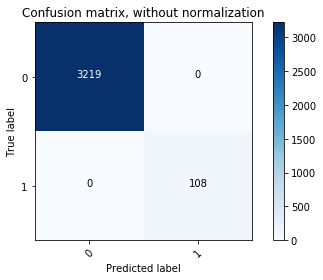

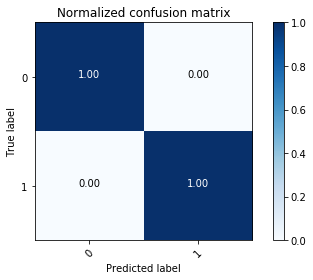

In [82]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = ['0','1']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

# Combine Data

This section I tried transforming the dataframes into pandas dataframes. This works, sort of, but it is very slow.

# Create Classification model

In [ ]:
cv = StratifiedKFold(n_splits=6)
classifier = xgb.XGBClassifier()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    print('round ',i+1)
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()